# Neural Machine Translation

Welcome to your first programming assignment for this week! 

You will build a Neural Machine Translation (NMT) model to translate human readable dates ("25th of June, 2009") into machine readable dates ("2009-06-25"). You will do this using an attention model, one of the most sophisticated sequence to sequence models. 

This notebook was produced together with NVIDIA's Deep Learning Institute. 

Let's load all the packages you will need for this assignment.

In [ ]:
import tensorflow as tf
gpu_fraction = 0.1
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [184]:
import tensorflow as tf
import keras
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np
from keras.preprocessing.text import Tokenizer
from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from at_nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

## 1 - Translating human readable dates into machine readable dates

The model you will build here could be used to translate from one language to another, such as translating from English to Hindi. However, language translation requires massive datasets and usually takes days of training on GPUs. To give you a place to experiment with these models even without using massive datasets, we will instead use a simpler "date translation" task. 

The network will input a date written in a variety of possible formats (*e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"*) and translate them into standardized, machine readable dates (*e.g. "1958-08-29", "1968-03-30", "1987-06-24"*). We will have the network learn to output dates in the common machine-readable format YYYY-MM-DD. 



<!-- 
Take a look at [nmt_utils.py](./nmt_utils.py) to see all the formatting. Count and figure out how the formats work, you will need this knowledge later. !--> 

### 1.1 - Dataset

We will train the model on a dataset of 10000 human readable dates and their equivalent, standardized, machine readable dates. Let's run the following cells to load the dataset and print some examples. 

In [63]:
#%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys 

sys.path.insert(0,'..')
from utils import plot_stroke

In [64]:
strokes = np.load('../data/strokes.npy',encoding='bytes')

In [77]:
with open('../data/sentences.txt') as f:
    texts = f.readlines()

In [170]:
"""
#idx = 3
for idx in range(10):
    stroke = strokes[idx]
    text = texts[idx]
    plot_stroke(stroke)
    print ('TEXT:', text)
    
"""
    

"\n#idx = 3\nfor idx in range(10):\n    stroke = strokes[idx]\n    text = texts[idx]\n    plot_stroke(stroke)\n    print ('TEXT:', text)\n    \n"

In [ ]:
mx = []
for i in range (len(texts)):
    mx.append(len(strokes[i])/len(texts[i]))
np.ceil(np.mean(mx))    

In [ ]:
'''
from keras.preprocessing.text import Tokenizer

max_words = 100
tokenizer = Tokenizer(num_words=max_words,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                   lower=False,
                                   split=" ",
                                   char_level=True)
x_train = tokenizer.sequences_to_matrix(texts, mode='binary')
y_train = keras.utils.to_categorical(y_train, num_classes)
###

from keras.preprocessing.text import Tokenizer

max_words = 100

tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
'''

In [ ]:
max_text_len = np.max([len(texts[i]) for i in range (len(texts))])
max_text_len

In [199]:

chars='ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz .#'  # for other char in texts


# unique contains all the unique characters in the file
unique = sorted(set(chars))

# creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(unique)}
idx2char = {i:u for i, u in enumerate(unique)}

num_char = len(char2idx)
print(num_char)

55


In [172]:
########## gives the best representation so far
max_stroke_len = 500
max_char_len = max_stroke_len/25
max_char_len

20.0

In [173]:
def check_char (char2idx,val):
    result = []
    if char2idx.get(val)!=None:
        result = char2idx[val]
    elif char2idx.get(val)==None :
        result = char2idx['#']
    return result

In [174]:
def check_char (char2idx,val):
    result = []
    if char2idx.get(val)!=None:
        result = char2idx[val]
    elif char2idx.get(val)==None :
        result = char2idx['#']
    return result

def str2num(texts):
    input_text = []
    for f in range(len(texts)):
        inps = texts[f]   
        data = list(map( lambda val: check_char (char2idx,val),inps ))
        input_text.append(data)
        #np.concatenate((a, b), axis=0)
    return np.vstack(input_text)

def pad_texts(text, max_char_len):  
    pads = max_char_len - len(text)
    for i in range(int(pads)):
        text = text+str(' ')
    return text

def tranc_text(texts, max_char_len):
    for i in range (len(texts)):
        if len(texts[i]) > max_char_len:
            texts[i] = texts[i][0:int(max_char_len)]

        elif len(texts[i]) < max_char_len:
            texts[i] = pad_texts(texts[i],max_char_len)
    return texts 

In [175]:
texts = tranc_text(texts, max_char_len)
n_texts = str2num(texts)
C = np.array(list(map(lambda x: to_categorical(x, num_classes=len(char2idx)), n_texts)))

print(C.shape)

(6000, 20, 55)


In [176]:
"""
##########
def pad_texts(text, max_char_len):  
    pads = max_char_len - len(text)
    for i in range(int(pads)):
        text = text+str(' ')
    return text

def tranc_text(texts, max_char_len):
    for i in range (len(texts)):
        if len(texts[i]) > max_char_len:
            texts[i] = texts[i][0:int(max_char_len)]

        elif len(texts[i]) < max_char_len:
            texts[i] = pad_texts(texts[i],max_char_len)
    return texts  

def str2num(texts):
    input_text = []
    for f in range(len(texts)):
        inps = texts[f]    
        data = [char2idx[i] for i in list(inps)]
        #data  = pad(data, max_text_len)                               #zeropad
        input_text.append(data)
        #np.concatenate((a, b), axis=0)
    return np.vstack(input_text)

###########
texts = tranc_text(texts, max_char_len)
chars = set(''.join(texts))
# unique contains all the unique characters in the file
unique = sorted(set(chars))
# creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(unique)}
idx2char = {i:u for i, u in enumerate(unique)}
n_texts = str2num(texts)
C = np.array(list(map(lambda x: to_categorical(x, num_classes=len(char2idx)), n_texts)))

print(C.shape)

"""

"\n##########\ndef pad_texts(text, max_char_len):  \n    pads = max_char_len - len(text)\n    for i in range(int(pads)):\n        text = text+str(' ')\n    return text\n\ndef tranc_text(texts, max_char_len):\n    for i in range (len(texts)):\n        if len(texts[i]) > max_char_len:\n            texts[i] = texts[i][0:int(max_char_len)]\n\n        elif len(texts[i]) < max_char_len:\n            texts[i] = pad_texts(texts[i],max_char_len)\n    return texts  \n\ndef str2num(texts):\n    input_text = []\n    for f in range(len(texts)):\n        inps = texts[f]    \n        data = [char2idx[i] for i in list(inps)]\n        #data  = pad(data, max_text_len)                               #zeropad\n        input_text.append(data)\n        #np.concatenate((a, b), axis=0)\n    return np.vstack(input_text)\n\n###########\ntexts = tranc_text(texts, max_char_len)\nchars = set(''.join(texts))\n# unique contains all the unique characters in the file\nunique = sorted(set(chars))\n# creating a mapping f

In [177]:
Tx = max_stroke_len
Ty = max_stroke_len

def pad_stroke(stroke,Ty):
    _npads = Ty - stroke.shape[0] 
    padded_stroke = np.vstack ([ stroke,np.zeros((_npads,3)) ])
    #padded_strokes.shape
    return padded_stroke

def tranc_stroke(stroke, Ty):
    if stroke.shape[0] >= Ty:
        stroke = stroke[:Ty,]
    elif stroke.shape[0] < Ty:
        stroke = pad_stroke(stroke,Ty)
    #return input_stroke,output_stroke
    return stroke

new_strokes = np.array(list(map(lambda x: tranc_stroke(x, Ty+1), strokes)))
Xoh = new_strokes[:,:Ty,:]
Yoh = new_strokes[:,1:Ty+1,:]

print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

Xoh.shape: (6000, 500, 3)
Yoh.shape: (6000, 500, 3)


#######################################








########################################

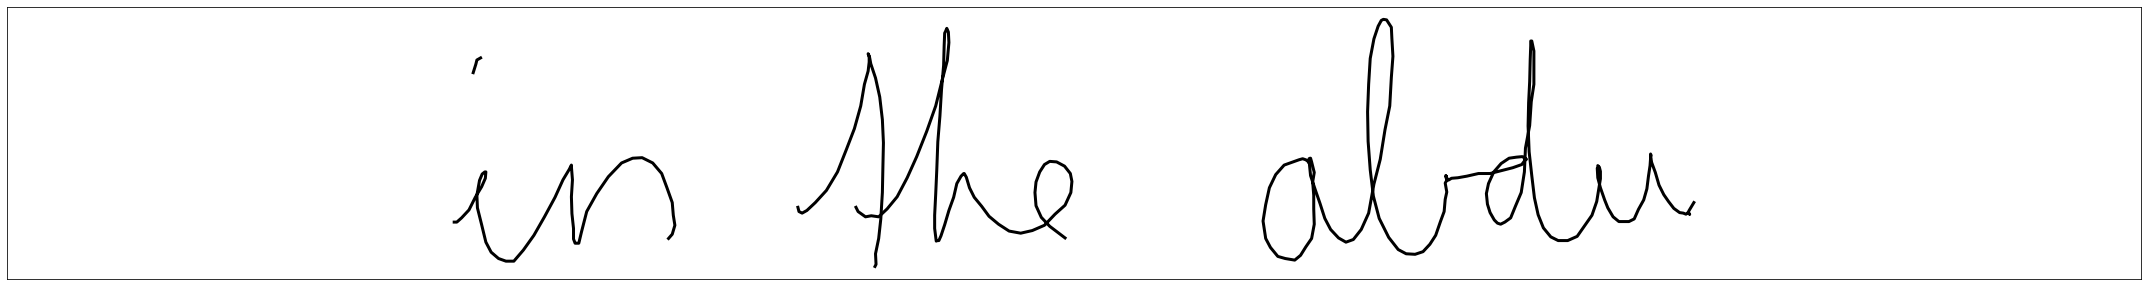

TEXT: in the abundance of 


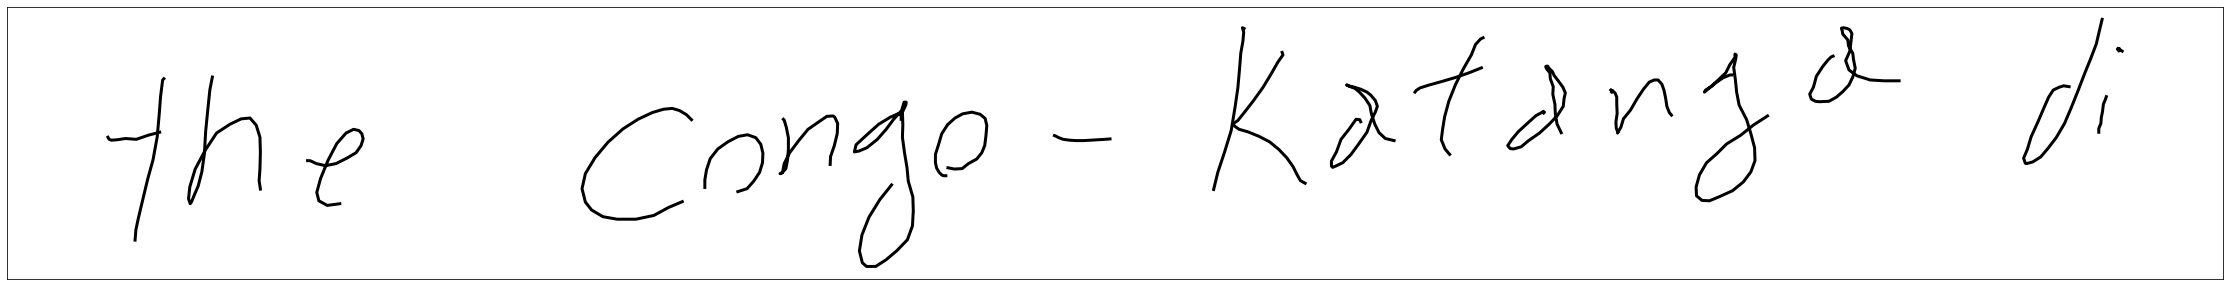

TEXT: the Congo-Katanga di


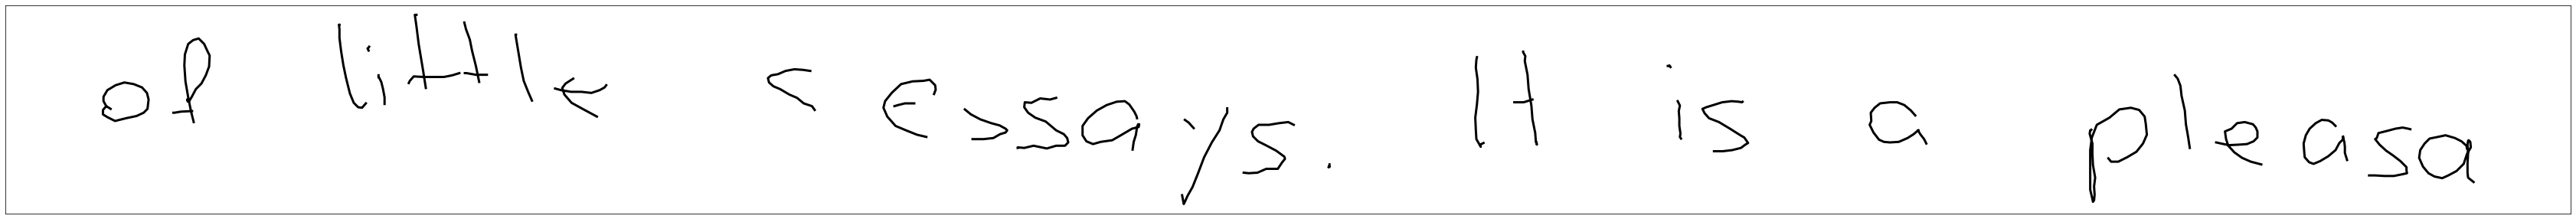

TEXT: of little s essays. 


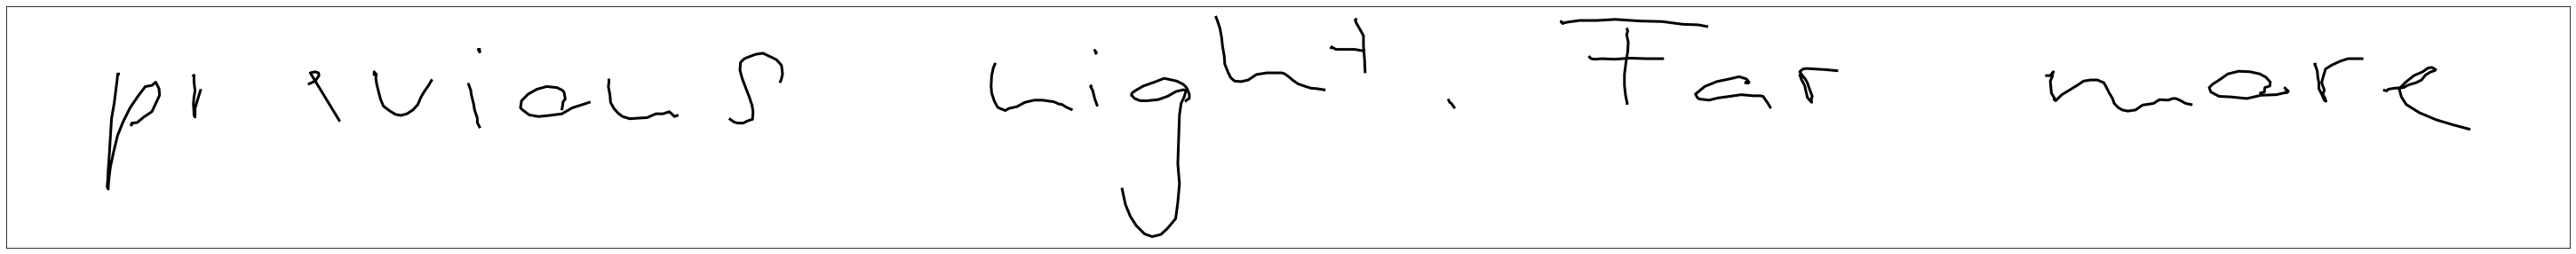

TEXT: previous night. Far 


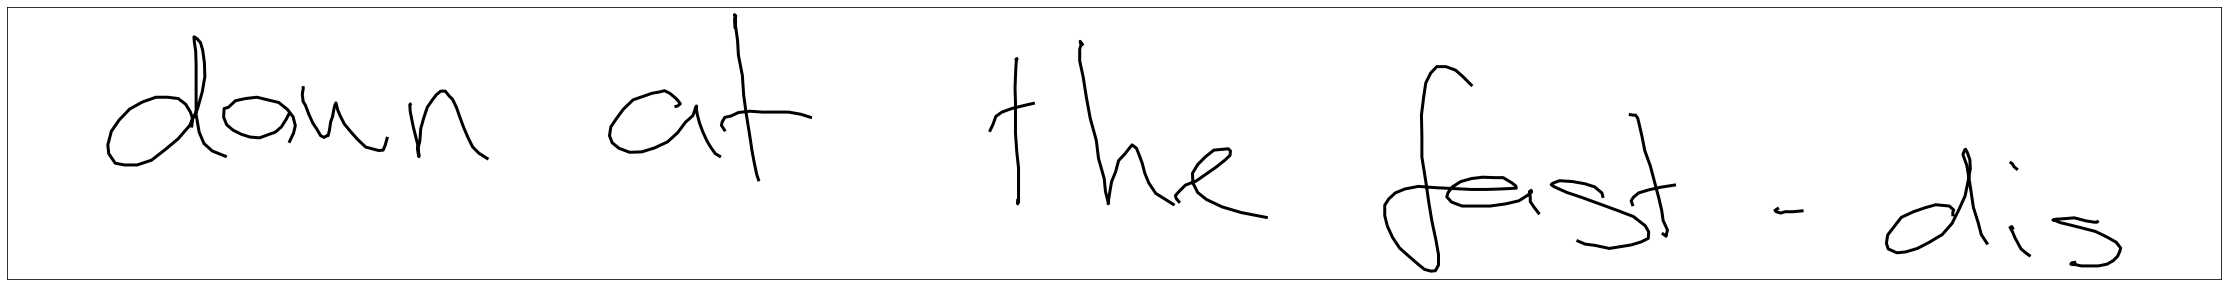

TEXT: down at the fast-dis


In [178]:
for idx in range(5):
    stroke = Xoh[idx]
    text = texts[idx]
    plot_stroke(stroke)
    print ('TEXT:', text)

In [190]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [ ]:
# GRADED FUNCTION: one_step_attention

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    ### START CODE HERE ###
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator ([s_prev,a])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas,a])
    ### END CODE HERE ###
    
    return context

In [198]:
C.shape

(6000, 20, 55)

In [207]:
Xoh.shape[2]

3

In [ ]:
n_a = 300
n_s = 300
input_feat_size = Xoh.shape[2]   #3
output_feat_size = Yoh.shape[2]   #3

post_activation_LSTM_cell = LSTM(n_s, return_state = True)
#output_layer = Dense(len(machine_vocab), activation=softmax)
output_layer = Dense(3, activation = "sigmoid")

In [ ]:
# GRADED FUNCTION: model

def model(Tx, Ty, n_a, n_s, input_feat_size, output_feat_size, max_char_len, num_char):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, input_feat_size))
    C = Input(shape=(max_char_len, num_char))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    ### START CODE HERE ###
    
    # Step 1: Define your pre-attention Bi-LSTM. Remember to use return_sequences=True. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True),input_shape=(Tx, input_feat_size))(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context,initial_state= [s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    
    model = Model(inputs=[X,C,s0,c0], outputs=outputs)

    ### END CODE HERE ###
    
    return model

In [ ]:
#human_vocab_size, machine_vocab_size = len(human_vocab), len(machine_vocab)
#model = model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size)

model = model(Tx, Ty, n_a, n_s, 3, 3)

In [ ]:
Ty

Let's get a summary of the model to check if it matches the expected output.

In [ ]:
model.summary()

In [ ]:
### START CODE HERE ### (≈2 lines)

opt = Adam(lr=0.005, decay=0.01, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
### END CODE HERE ###

In [ ]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

Let's now fit the model and run it for one epoch.

In [ ]:
outputs[0].shape

In [ ]:
Yoh.shape

In [ ]:
outputs[0].shape

In [ ]:
Xoh.shape

In [ ]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=10)

In [ ]:
source = np.zeros((1,300,3))

In [ ]:
for i in range(100):
    
    #source = string_to_int(example, Tx, human_vocab)
    #source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    #source = source.T[np.newaxis,:,:]  #changed the shape
    prediction = model.predict([source, s0, c0])

In [ ]:
prediction

In [ ]:
model.load_weights('models/model.h5')

You can now see the results on new examples.

In [ ]:
Xoh.shape

In [ ]:
print(source.shape)
print(source.T.shape)
print(source.T[np.newaxis,:,:].shape)

In [ ]:
source.T.shape


In [ ]:
Ty

In [ ]:
len(_vocab)

In [ ]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    #source = source.T[np.newaxis,:,:]  #changed the shape
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

You can also change these examples to test with your own examples. The next part will give you a better sense on what the attention mechanism is doing--i.e., what part of the input the network is paying attention to when generating a particular output character. 

## 3 - Visualizing Attention (Optional / Ungraded)

Since the problem has a fixed output length of 10, it is also possible to carry out this task using 10 different softmax units to generate the 10 characters of the output. But one advantage of the attention model is that each part of the output (say the month) knows it needs to depend only on a small part of the input (the characters in the input giving the month). We can  visualize what part of the output is looking at what part of the input.

Consider the task of translating "Saturday 9 May 2018" to "2018-05-09". If we visualize the computed $\alpha^{\langle t, t' \rangle}$ we get this: 

<img src="images/date_attention.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 8**: Full Attention Map</center></caption>

Notice how the output ignores the "Saturday" portion of the input. None of the output timesteps are paying much attention to that portion of the input. We see also that 9 has been translated as 09 and May has been correctly translated into 05, with the output paying attention to the parts of the input it needs to to make the translation. The year mostly requires it to pay attention to the input's "18" in order to generate "2018." 



### 3.1 - Getting the activations from the network

Lets now visualize the attention values in your network. We'll propagate an example through the network, then visualize the values of $\alpha^{\langle t, t' \rangle}$. 

To figure out where the attention values are located, let's start by printing a summary of the model .

In [ ]:
model.summary()

Navigate through the output of `model.summary()` above. You can see that the layer named `attention_weights` outputs the `alphas` of shape (m, 30, 1) before `dot_2` computes the context vector for every time step $t = 0, \ldots, T_y-1$. Lets get the activations from this layer.

The function `attention_map()` pulls out the attention values from your model and plots them.

In [ ]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)

On the generated plot you can observe the values of the attention weights for each character of the predicted output. Examine this plot and check that where the network is paying attention makes sense to you.

In the date translation application, you will observe that most of the time attention helps predict the year, and hasn't much impact on predicting the day/month.

### Congratulations!


You have come to the end of this assignment 

<font color='blue'> **Here's what you should remember from this notebook**:

- Machine translation models can be used to map from one sequence to another. They are useful not just for translating human languages (like French->English) but also for tasks like date format translation. 
- An attention mechanism allows a network to focus on the most relevant parts of the input when producing a specific part of the output. 
- A network using an attention mechanism can translate from inputs of length $T_x$ to outputs of length $T_y$, where $T_x$ and $T_y$ can be different. 
- You can visualize attention weights $\alpha^{\langle t,t' \rangle}$ to see what the network is paying attention to while generating each output.

Congratulations on finishing this assignment! You are now able to implement an attention model and use it to learn complex mappings from one sequence to another. 